# Load Packages
- Data and data loader for continual learning are contained inside core50 folder
- CLDIM packages are organized in subfolders of DIM one. Wrapper files are wrapper used to organize easily traning/validation/testing of CLDIM during various tasks


In [9]:
import os
import time
import copy
import torch
import numpy as np

import sys 
path = '/home/jbonato/Documents/cvpr_clvision_challenge/'
sys.path.append(path)
from core50.dataset import CORE50
####
sys.path.append(path+'DIM/')
from DIM.wrapperNI import *
from DIM.wrapperNC import *
from DIM.wrapperNIC import *



# Chose scenario
Algorithms details are described in section 3 (Results) of the report

If you want to change backbone go to networks/DIM_model.py and install a different backbone such as RexNext50 ecc.

In [10]:
############ TASK NI
scenario = 'ni'
sub_dir = 'ni'
Load = False
preload_data = True

############ TASK NC
# scenario = 'multi-task-nc'
# sub_dir = 'multi-task-nc'
# Load = False
# preload_data = True

############ TASK NIC
# scenario = 'nic'
# sub_dir = 'nic'
# Load = False
# preload_data = True


# Load Dataset

In [11]:
# Create the dataset object
dataset = CORE50(root=path+'core50/data/', scenario=scenario,preload=preload_data)
full_valdidset = dataset.get_full_valid_set()

Loading data...
Loading paths...
Loading LUP...
Loading labels...
preparing CL benchmark...


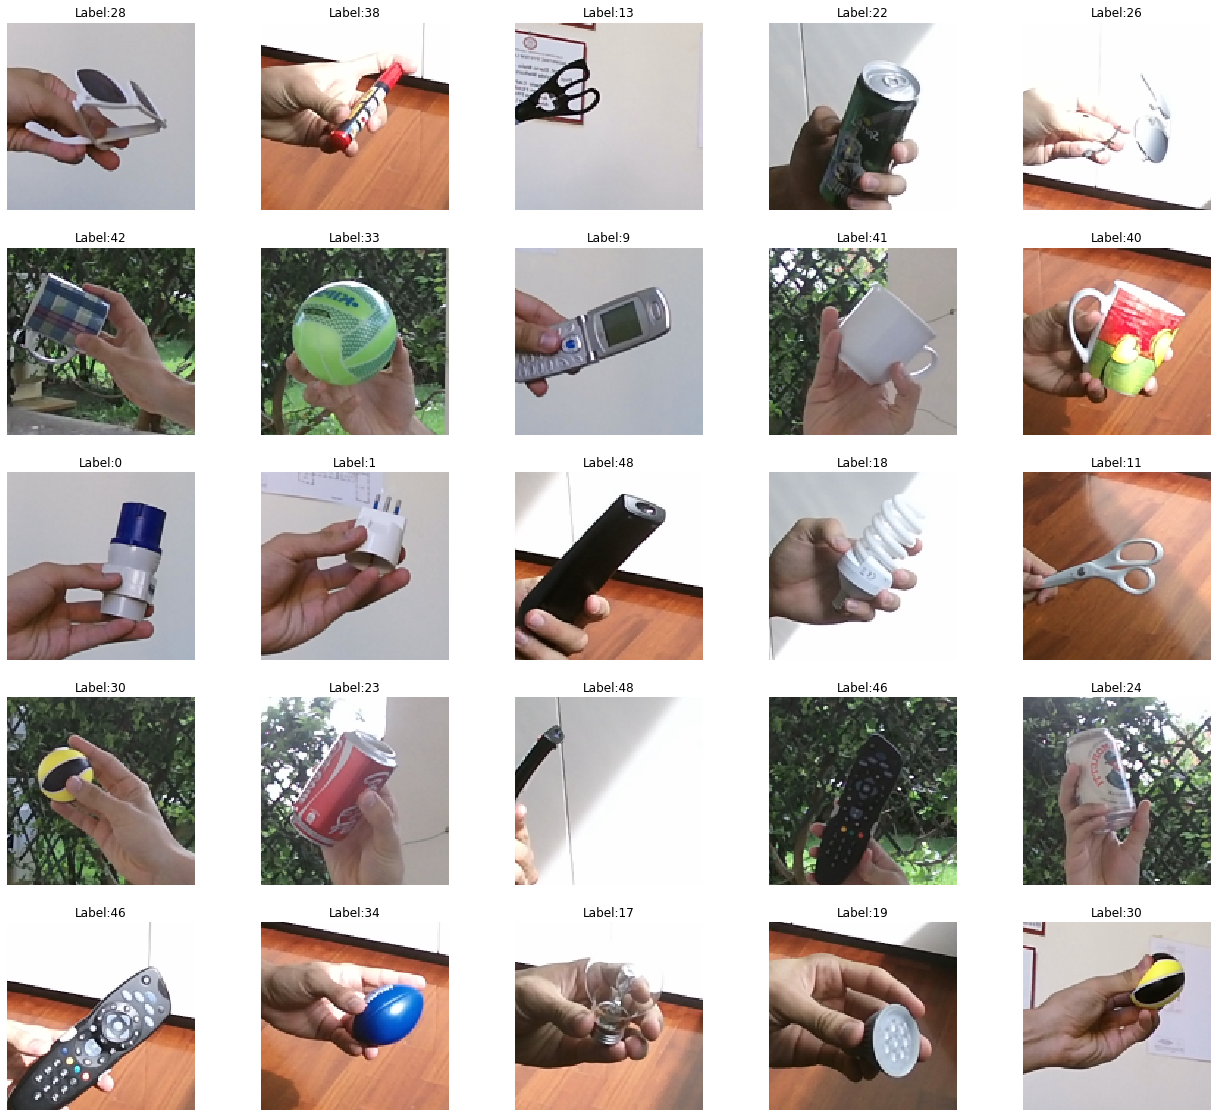

In [18]:
display_samp=True
if display_samp:
    images = full_valdidset[0][0][0]
    lab = full_valdidset[0][0][1]
    fig,ax = plt.subplots(figsize=(22,20),nrows=5,ncols=5)
    for i in range(25):
        idx = np.random.choice(np.arange(images.shape[0]),1)
        ax[i//5,i%5].imshow(images[idx[0]].astype(np.uint8))
        ax[i//5,i%5].set_title('Label: '+str(int(lab[idx[0]])))
        ax[i//5,i%5].axis('off')

# Perform Training and validation

How CLDIM is trained during these different scenario is described in both section 2 (Methods) and 3 (Results) of the report.
Validation set is used to evaluate CLDIM during different tasks. It is never used as cross validation set to optimize CLDIM hyperparameters

In [7]:
start = time.time()
#################################  Get the validation set
print("Recovering validation set...")

device0 = torch.device('cuda:0')

################################ # code for training 
if scenario=='ni':
    NI = NI_wrap(dataset,full_valdidset,device=device0,path=path,load=Load)
elif scenario=='multi-task-nc':
    NI = NC_wrap(dataset,full_valdidset,device=device0,path=path,load=Load)
elif scenario=='nic':
    NI = NIC_wrap(dataset,full_valdidset,device=device0,path=path,load=Load)

stats,valid_acc = NI.train()
ram_usage = np.asarray(stats['ram'])
ext_mem_sz = np.asarray(stats['disk'])

#################################  Generate submission folder inside notebook folder

sub_dir = 'submissions/' + sub_dir
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

################################## generating metadata.txt: with all the data used for the CLScore
elapsed = (time.time() - start) / 60
print("Training Time: {}m".format(elapsed))

with open(sub_dir + "/metadata.txt", "w") as wf:
    for obj in [
        np.average(valid_acc), elapsed, np.average(ram_usage),
        np.max(ram_usage), np.average(ext_mem_sz), np.max(ext_mem_sz)
    ]:
        wf.write(str(obj) + "\n")
        
with open(sub_dir + "/valid_hist.txt", "w") as wf:
    for obj in [valid_acc]:
        wf.write(str(obj) + "\n")

   


Loading data...
Loading paths...
Loading LUP...
Loading labels...
preparing CL benchmark...
Recovering validation set...
Batch number: 0


KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

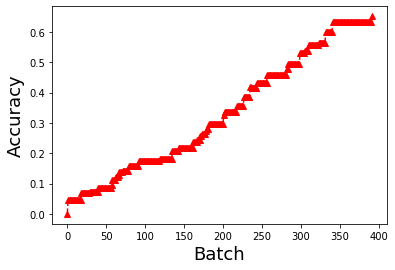

In [4]:
plt.plot(np.arange(valid_acc.shape[0]),valid_acc,'r--^')
plt.xlabel('Batch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

# Test set results
Unfortunately test set labels are not available yet. Test set score can be obtained submitting results to Colab :
https://competitions.codalab.org/competitions/23317
Probably after the end of the challenge organizers will share also these labels 

In [ ]:
print("Final inference on test set...")
full_testset = dataset.get_full_test_set()

pred = NI.test(full_testset,standalone=False)

with open(sub_dir + "/test_preds.txt", "w") as wf:
    for jj in range(pred.shape[0]):
        wf.write(str(pred[jj]) + "\n")

print("Experiment completed.")